# Détection de visage - SY32

### Import des librairies
On définit également les chemins principaux et on charge le fichier de données.

Les fenêtres étant de tailles différentes, il est nécessaire de connaître la taille de fenêtre la plus petite dont nous disposons afin que nous ne soyons pas contraints de zoomer une image. Nous pourrions également établir une limite afin de rejeter les images dont la taille de fenêtre est en dessous d'un certain seuil (il serait absurde de choisir une taille de fenêtre d'un pixel...).

In [1]:
import numpy as np
from skimage import io
from skimage import util
from skimage.transform import resize
from skimage import color
#from skimage import feature
from sklearn import svm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image


absolutePath = "/Users/guillaume/Cloud/WORK/UTC/GI02/SY32/TDXu/Projet/"
pathTrain = absolutePath + "projetface/train/"
pathTest =  absolutePath + "projetface/test/"
pathFile = absolutePath + "projetface/label.txt"
data = np.loadtxt(pathFile)

In [2]:
def minFace(data):
    return int(np.min(data[:,3:]))

newSize = minFace(data)
print("minFace =", newSize)

minFace = 30


La fonction suivante permet tout simplement d'afficher une image d'apprentissage en affichant dessus son rectangle correspondant.

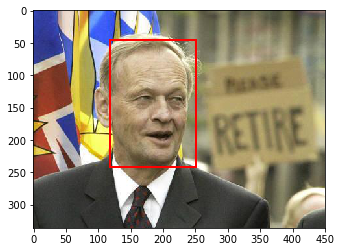

In [3]:
def afficherImgRect(n, data, pathTrain):
    # Charger l'image
    img = np.array(Image.open(pathTrain +"%04d"%(n)+".jpg"), dtype=np.uint8)
    # Créer la figure et les axes
    fig,ax = plt.subplots(1)
    # Afficher l'image
    ax.imshow(img)
    # Créer le rectangle 
    xcorner, ycorner, width, height = data[n-1][1:]
    rect = patches.Rectangle((xcorner, ycorner), width, height,linewidth=2,edgecolor='r', facecolor='none')
    # Ajouter le rectangle sur l'image
    ax.add_patch(rect)
    plt.show()

afficherImgRect(14, data, pathTrain)

La fonction suivante permet de cropper l'image selon ce rectangle, ainsi que la redimensionner en carré à la taille $newsize$ si l'argument est renseigné.

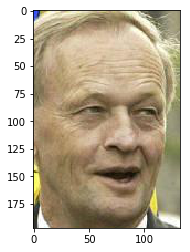

In [12]:
def cropImage(n, data, pathTrain, newsize=0):
    img = np.array(Image.open(pathTrain +"%04d"%(n)+".jpg"), dtype=np.uint8)
    x, y, w, h = map(int, data[n-1][1:])
    img = img[y:y+h, x:x+w]
    if newsize:
        img = resize(img, (newsize, newsize), mode='reflect')
    return img

image = cropImage(14,data,pathTrain)
fig,ax = plt.subplots(1)
ax.imshow(image)
plt.show()

Pour des questions de simplicité, nous voudrions que les images croppées soient carrées de la taille minimale calculée précédemment. La fonction suivante modifie la variable data afin de transformer toutes les coordonnées et tailles de telle sorte qu'il s'agisse de carrés (centrés par rapport au rectangle fourni).

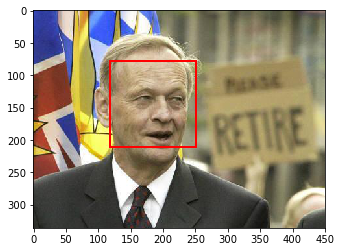

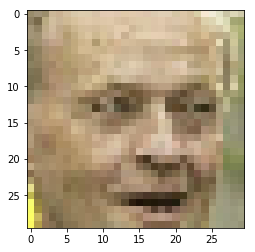

In [20]:
def dataSquare(data):
    # Récupération des "rectangles"
    newData = np.array(data)
    # Récupération du minimum entre la largeur et la hauteur
    minwh = np.minimum(data[:,3], data[:,4])
    # Modification de la largeur
    newData[:,1] += (data[:,3]-minwh)//2
    # Modification de la hauteur
    newData[:,2] += (data[:,4]-minwh)//2
    # Transformation des rectangles en carrés
    newData[:,3:] = np.transpose(np.array([minwh, minwh]))
    return newData

# Calcul des nouvelles coordonnées
dataPositif = dataSquare(data)

# Affichage des coordonnées sur une images
afficherImgRect(14, dataPositif, pathTrain)

#Recadrement et redimensionnement de l'image
image = cropImage(14,dataPositif,pathTrain, newSize)
fig,ax = plt.subplots(1)
ax.imshow(image)
plt.show()

Grâce à la fonction précédente, nous obtenons nos exemples positifs d'apprentissage. La fonction suivante retourne l'ensemble des exemples positifs en noir et blanc (cela allège la quantité de données en la divisant par trois, la composante couleur n'étant pas prise en compte dans notre analyse).

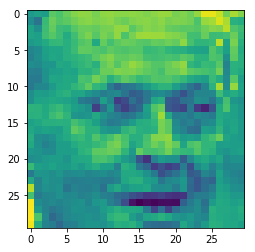

In [21]:
def donnesImages(data, pathTrain, newsize):
    images = np.zeros((len(data),newsize,newsize))
    for i in range(len(data)):
        images[i] = color.rgb2gray(cropImage(i+1, data, pathTrain, newsize))
    return images

exemplesPositifs = donnesImages(dataPositif, pathTrain, newSize)
fig,ax = plt.subplots(1)
ax.imshow(exemplesPositifs[13])
plt.show()

Il nous faut également générer des exemples négatifs de façon aléatoire, ceux-ci devant recouvrir au plus 50% de l'exemple positif. Écrivons donc une fonction permettant d'obtenir le taux de recouvrement relatif à deux fenêtres (entre 0 et 100%).

In [22]:
def recouvrement(x1, y1, w1, h1, x2, y2, w2, h2):
    xinter = max(0, min(x1+w1,x2+w2) - max(x1,x2))
    yinter = max(0, min(y1+h1,y2+h2) - max(y1,y2));
    ainter = xinter * yinter;
    aunion = (w1*h1) + (w2*h2) - ainter
    return ainter/aunion

print("Recouvrement total:", recouvrement(10,10,30,30,10,10,30,30))
print("Recouvrement nul:", recouvrement(10,10,30,30,40,40,30,30))
print("Recouvrement partiel:", recouvrement(10,10,30,30,20,20,30,30))

Recouvrement total: 1.0
Recouvrement nul: 0.0
Recouvrement partiel: 0.2857142857142857


Considérons un exemple négatif si son recouvrement est inférieur à 0.5. Nous recherchons une fonction retournant l'ensemble des exemples négatifs en noir et blanc de la taille de la fenêtre minimale que nous allons utiliser pour l'apprentissage, ceux-ci étant tirés aléatoirement (aléas: échelle, $x$, $y$) de telle sorte qu'il y en ait n par image (généralement entre 10 et 20). 

Pour rappel, nous avons déterminé $newSize$ de telle sorte qu'il s'agisse de la plus petite fenêtre imaginable. La fenêtre doit donc être carrée et être de taille aléatoire supérieure à $newSize$, sans déborder de l'image. La fonction suivante retourne la position ainsi que la taille d'une fenêtre correspondant à un exemple négatif tiré aléatoirement dans la $n$ième image.

In [23]:
def negatifRandom(data,pathTrain,newsize,n):
    while True:
        # Récupération de l'image
        img = np.array(Image.open(pathTrain +"%04d"%(n)+".jpg"), dtype=np.uint8)
        # Récupération de ses caractéristiques
        x1, y1, w1, h1 = map(int, data[n-1][1:])
        w, h = [len(img[0]), len(img)]
        # Choix aléatoire d'une taille de fenêtre
        taille = int(np.random.uniform(low=newsize, high=min(w,h)))
        # Choix aléatoire de la position de la fenêtre
        x = int(np.random.uniform(low=0, high=w-taille))
        y = int(np.random.uniform(low=0, high=h-taille))
        # Test du score de recouvrement de la fenêtre
        if recouvrement(x1,y1,w1,h1,x,y,taille,taille) < 0.5:
            return x, y, taille

print(negatifRandom(data,pathTrain,newSize,14))

(170, 198, 67)


Grâce à la fonction précédente, 

In [24]:
def exemplesNegatifs(n, data, pathTrain, newsize):
    images = np.zeros((len(data)*n,newsize,newsize))
    # Pour chaque image
    for i in range(len(data)):
        # On cherche n exemples négatifs
        for j in range(n):
            print("image",i, " (i:",i,", j:",j,", ite",(i*n) +j,")")
    return images

exNeg = exemplesNegatifs(10, data, pathTrain, newSize)

image 0  (i: 0 , j: 0 , ite 0 )
image 0  (i: 0 , j: 1 , ite 1 )
image 0  (i: 0 , j: 2 , ite 2 )
image 0  (i: 0 , j: 3 , ite 3 )
image 0  (i: 0 , j: 4 , ite 4 )
image 0  (i: 0 , j: 5 , ite 5 )
image 0  (i: 0 , j: 6 , ite 6 )
image 0  (i: 0 , j: 7 , ite 7 )
image 0  (i: 0 , j: 8 , ite 8 )
image 0  (i: 0 , j: 9 , ite 9 )
image 1  (i: 1 , j: 0 , ite 10 )
image 1  (i: 1 , j: 1 , ite 11 )
image 1  (i: 1 , j: 2 , ite 12 )
image 1  (i: 1 , j: 3 , ite 13 )
image 1  (i: 1 , j: 4 , ite 14 )
image 1  (i: 1 , j: 5 , ite 15 )
image 1  (i: 1 , j: 6 , ite 16 )
image 1  (i: 1 , j: 7 , ite 17 )
image 1  (i: 1 , j: 8 , ite 18 )
image 1  (i: 1 , j: 9 , ite 19 )
image 2  (i: 2 , j: 0 , ite 20 )
image 2  (i: 2 , j: 1 , ite 21 )
image 2  (i: 2 , j: 2 , ite 22 )
image 2  (i: 2 , j: 3 , ite 23 )
image 2  (i: 2 , j: 4 , ite 24 )
image 2  (i: 2 , j: 5 , ite 25 )
image 2  (i: 2 , j: 6 , ite 26 )
image 2  (i: 2 , j: 7 , ite 27 )
image 2  (i: 2 , j: 8 , ite 28 )
image 2  (i: 2 , j: 9 , ite 29 )
image 3  (i: 3 , j: 